## Setup

In [1]:
import pandas as pd
from services.clean_data import *
from services.eval import *
from services.models import *
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set maximum rows to None (no truncation)
pd.set_option('display.max_rows', None)

# Set maximum columns to None (no truncation)
pd.set_option('display.max_columns', None)

/home/joao/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-20 22:07:56.447678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734732476.472233   16669 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734732476.479144   16669 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 22:07:56.501360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations

## Read Input

In [2]:
awards_players = clear_awards(pd.read_csv('data/awards_players.csv'))
coaches = pd.read_csv('data/coaches.csv')
coaches_s11 = pd.read_csv('data/s11/coaches.csv')
coaches = clear_coaches(pd.concat([coaches, coaches_s11]))
players_teams = pd.read_csv('data/players_teams.csv')
players_teams_s11 = pd.read_csv('data/s11/players_teams.csv')
players_teams = clear_players_teams(pd.concat([players_teams, players_teams_s11]))
players = clear_players(pd.read_csv('data/players.csv'))
series_post = clear_series_post(pd.read_csv('data/series_post.csv'))
teams_post = clear_teams_post(pd.read_csv('data/teams_post.csv'))
df = pd.read_csv('data/teams.csv')
df_s11 = pd.read_csv('data/s11/teams.csv')
df = clear_teams(pd.concat([df, df_s11]))

## Additional features

To use every table in the input, we need to merge them into the main table. However, since the tables have different sizes, we need to merge them smartly, by adding additional features/columns to the main table which correspond to one or more columns in the other tables.

### Awards

Cumulative awards for each player that will play on each team next season, for the current given awards until the actual season.

For example, if the team A is playing in the **9th season**, the awards will be the sum of all awards won until **season 9** by the players playing on **season 10** on team A.

In [3]:
# Step 1: Calculate the total awards per player for each year
player_awards_by_year = awards_players.groupby(['playerID', 'year']).size().reset_index(name='awards_count')

# Step 2: Ensure all years are represented for each player
# Create a full set of years for each player
all_years = pd.DataFrame({'year': range(1, awards_players['year'].max() + 1)})  # Assuming years start from 1
player_years = player_awards_by_year['playerID'].unique()
full_player_data = pd.DataFrame([(player, year) for player in player_years for year in range(1, awards_players['year'].max() + 1)], columns=['playerID', 'year'])

# Merge with original player data to fill in missing years (with NaN awards_count for missing years)
player_awards_by_year = pd.merge(full_player_data, player_awards_by_year, on=['playerID', 'year'], how='left')

# Fill missing awards_count with 0 where no award was given that year
player_awards_by_year['awards_count'].fillna(0, inplace=True)

# Step 3: Calculate cumulative awards per player (cumsum over awards_count)
player_awards_by_year['cumulative_awards'] = player_awards_by_year.groupby('playerID')['awards_count'].cumsum()

# Step 4: Calculate total awards per coach for each year (using coachID instead of playerID)
coach_awards_by_year = awards_players[awards_players['playerID'].isin(coaches['coachID'])]
coach_awards_by_year = coach_awards_by_year.groupby(['playerID', 'year']).size().reset_index(name='awards_count')

# Step 5: Ensure all years are represented for each coach
# Create a full set of years for each coach
coach_ids = coach_awards_by_year['playerID'].unique()  # Same as 'coachID' here
full_coach_data = pd.DataFrame([(coach, year) for coach in coach_ids for year in range(1, awards_players['year'].max() + 1)], columns=['playerID', 'year'])

# Merge with original coach data to fill in missing years
coach_awards_by_year = pd.merge(full_coach_data, coach_awards_by_year, on=['playerID', 'year'], how='left')

# Fill missing awards_count with 0 where no award was given that year
coach_awards_by_year['awards_count'].fillna(0, inplace=True)

# Step 6: Calculate cumulative awards per coach (cumsum over awards_count)
coach_awards_by_year['cumulative_awards'] = coach_awards_by_year.groupby('playerID')['awards_count'].cumsum()

# Rename playerID to coachID to distinguish coaches
coach_awards_by_year.rename(columns={'playerID': 'coachID'}, inplace=True)

# Combine both player and coach awards
combined_awards_by_year = pd.concat([player_awards_by_year, coach_awards_by_year])

# Step 7: Merging with the next year's stats (for players and coaches)
# Shift players_teams data to associate players of year X+1 with teams in year X
players_teams_next_year = players_teams.copy()
players_teams_next_year['year'] -= 1  # Shift years back to merge with current awards
players_teams_next_year = players_teams_next_year[players_teams_next_year['year'] > 0]

# Merge cumulative awards for players
team_players_awards = pd.merge(
    players_teams_next_year,
    combined_awards_by_year[['playerID', 'year', 'cumulative_awards']],
    on=['playerID', 'year'],
    how='left'
)

# Shift coaches data to associate coaches of year X+1 with teams in year X
coaches_next_year = coaches.copy()
coaches_next_year['year'] -= 1  # Shift years back to merge with current awards
coaches_next_year = coaches_next_year[coaches_next_year['year'] > 0]

# Merge cumulative awards for coaches
team_coaches_awards = pd.merge(
    coaches_next_year,
    combined_awards_by_year[['coachID', 'year', 'cumulative_awards']],
    on=['coachID', 'year'],
    how='left'
)

# Step 8: Combine and Aggregate
# Standardize column names to allow concatenation
team_coaches_awards = team_coaches_awards.rename(columns={'coachID': 'playerID'})  # Treat coaches as players for processing

# Concatenate player and coach awards
team_players_awards = pd.concat([team_players_awards, team_coaches_awards], ignore_index=True)

# Group by team and year, summing cumulative awards
team_players_awards = team_players_awards.groupby(['tmID', 'year'], as_index=False).agg({'cumulative_awards': 'sum'})

# Fill missing values (for players/coaches with no awards) with 0
team_players_awards['cumulative_awards'].fillna(0, inplace=True)

# Step 9: Merge the result with the main team dataframe (df)
df = df.merge(team_players_awards[['tmID', 'year', 'cumulative_awards']], on=['tmID', 'year'], how='left')

# Fill missing values for teams that don't have any data for the next year
df['cumulative_awards'].fillna(0, inplace=True)

### Coaches

Current winning percentage of the coaches that will coach each team next season.

In [4]:
# Step 1: Calculate cumulative stats for each coach (up to their current year)
coaches['cumulative_wins'] = coaches.groupby('coachID')['coach_won'].cumsum()
coaches['cumulative_losses'] = coaches.groupby('coachID')['coach_lost'].cumsum()
coaches['cumulative_WR'] = coaches['cumulative_wins'] / (coaches['cumulative_wins'] + coaches['cumulative_losses'])

# Step 2: Shift the year for coaches to assign the correct future coach for each team
future_coaches = coaches[['coachID', 'tmID', 'year']].copy()
future_coaches['year'] = future_coaches['year'] + 1  # Assign future coach to the current year (team year)

# Step 3: Merge cumulative WR for the coaches on the team (using current year stats for the future coach)
cumulative_stats = coaches[['coachID', 'year', 'cumulative_WR']]
future_coaches_stats = pd.merge(future_coaches, cumulative_stats, on=['coachID', 'year'], how='left')

# Step 4: Merge future coaches' stats into the teams DataFrame
df = pd.merge(df, future_coaches_stats, on=['tmID', 'year'], how='left')

# Step 5: Handle missing values (teams with no coach yet assigned in future years)
df['cumulative_WR'].fillna(0, inplace=True)

# Step 6: Separate for first and second coaches
# For teams with a second coach (stint == 2), we'll create secondCoachWR
first_coach_wr = coaches[coaches['stint'] == 1][['year', 'tmID', 'cumulative_WR']].rename(columns={'cumulative_WR': 'firstCoachWR'})
second_coach_wr = coaches[coaches['stint'] == 2][['year', 'tmID', 'cumulative_WR']].rename(columns={'cumulative_WR': 'secondCoachWR'})

# For teams where the same coach is assigned to both positions (stint == 0), we'll use the same WR
same_coach_wr = coaches[coaches['stint'] == 0][['year', 'tmID', 'cumulative_WR']]
same_coach_wr['firstCoachWR'] = same_coach_wr['cumulative_WR']
same_coach_wr['secondCoachWR'] = same_coach_wr['cumulative_WR']
same_coach_wr = same_coach_wr[['year', 'tmID', 'firstCoachWR', 'secondCoachWR']]

# Combine the coach data for first and second coach WR
combined_coach_wr = pd.concat([first_coach_wr, second_coach_wr, same_coach_wr], axis=0).drop_duplicates(subset=['year', 'tmID'])

# Step 7: Merge combined coach WR data into the teams DataFrame (df)
df = pd.merge(df, combined_coach_wr, on=['tmID', 'year'], how='left')

# Step 8: Fill missing values with 0 where no coach data exists
df['firstCoachWR'].fillna(0, inplace=True)
df['secondCoachWR'].fillna(0, inplace=True)

# Step 9: Clean up the data to make sure no duplicate team-year pairs exist
df = df.drop_duplicates(subset=['tmID', 'year'])

# Step 10: Final sort and display (optional for cleaner output)
df.sort_values(by=['franchID', 'year'], inplace=True)

### Top Players

Count of top 5 players for each team. The top 5 players are the players with the most points scored in all seasons.

In [5]:
all_time_best_players = players_teams.groupby('playerID')["points"].sum().reset_index().sort_values(by=['points'], ascending=False)
top_all_time_best_players = all_time_best_players.merge(players_teams, on=['playerID']).groupby('playerID')
top_all_time_best_players = top_all_time_best_players.head(5)

tmid_counts = top_all_time_best_players['tmID'].value_counts().reset_index()
tmid_counts.columns = ['tmID', 'tmID_count']

tmid_counts = tmid_counts.rename(columns={'tmID_count': 'number_of_top_players'})

df = df.merge(tmid_counts, on=['tmID'], how='left')
df['number_of_top_players'].fillna(0, inplace=True)

### Team Statistics

Team statistics calculated with the data from the main table.

In [6]:
df['shot_accuracy'] = (df['o_fgm'] + df['o_3pm']) / (df['o_fga']+ df['o_3pa'])
df['defensive_accuracy'] = (df['d_fgm'] + df['d_ftm'] + df['d_3pm']) / (df['d_fga'] + df['d_fta'] + df['d_3pa'])
df['win_rate'] = (df['won']) / (df['won'] + df['lost'])
df["fg_effeciency"] = (df['o_fgm']  + df['o_3pm']*0.5 )/ (df['o_fga'])
df["shoot_percentage"] = (df['o_pts']  )/ (2*(df['o_fga']+0.44*df['o_fta']))
df.loc[df['year'] == 11, 'playoff'] = 'N' # No playoffs in year 11 since it is unknown
df["n_playoff"] = (
    df.assign(playoff_numeric=(df["playoff"] == 'Y'))
    .groupby("franchID")["playoff_numeric"]  # Group by team
    .cumsum()  # Cumulative sum of playoff appearances
)

## Playoff Next Year

To assign the playoff status for each team next season, we shift the playoff status of the current season to the previous season.

In [7]:
df.loc[df['year'] == 11, 'playoff'] = 'N'
df = df.drop_duplicates(subset=['tmID', 'year'])
df = df.sort_values(by=['franchID', 'year'])
df['playoffNextYear'] = df['playoff'].shift(-1)
df.loc[df['franchID']!= df['franchID'].shift(-1),'playoffNextYear'] = None
df.dropna(subset= ['playoffNextYear'], inplace=True)

df['playoff'] = df['playoff'] == 'Y'
df['playoffNextYear'] = df['playoffNextYear'] == 'Y'
df = pd.merge(df, teams_post, on=["tmID", 'year'], how='left')
df.fillna(0, inplace=True)

## Features and Target Used

Inital features, later filtered with the feature selection for each model.

In [8]:

features = [
    "playoff", "W", "L", "cumulative_awards", "number_of_top_players", "rank", "firstRound", "semis", "finals",
    "homeW", "homeL", "awayW", "awayL", "GP", "min", "confW", "confL", "attend","defensive_accuracy",
    "o_reb", "d_reb", "d_to", "d_stl", "d_blk","shot_accuracy","win_rate", "o_dreb","o_oreb","d_oreb","d_dreb",
    "fg_effeciency","shoot_percentage", "firstCoachWR", "secondCoachWR"
]

target = 'playoffNextYear'

## Data Analysis

### Correlation Heatmap

/tmp/ipykernel_16669/2501587892.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[features] = scaler.fit_transform(df_subset[features])


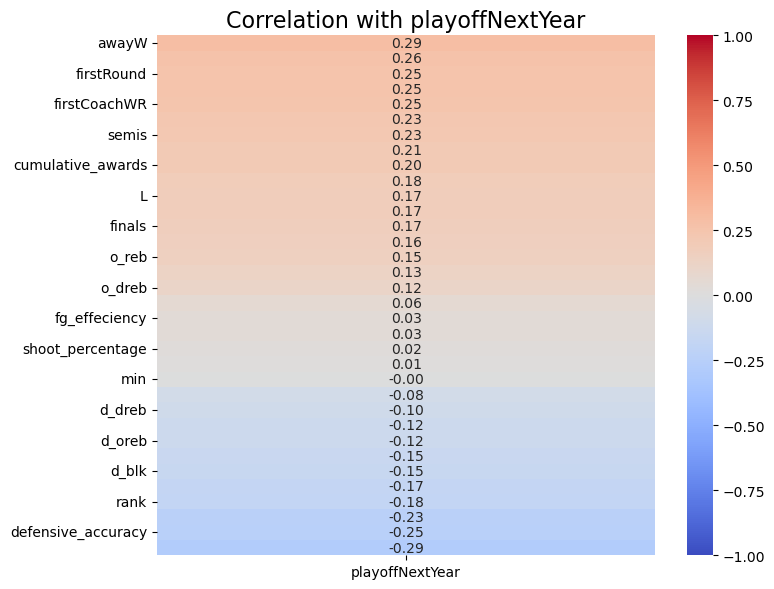

In [9]:
# Step 1: Select the relevant features and target
selected_columns = features + [target]

# Create a subset of the dataframe with the selected features
df_subset = df[selected_columns]

# Step 2: Normalize the features (Standardization)
scaler = StandardScaler()

# Normalize all features (excluding the target)
df_subset[features] = scaler.fit_transform(df_subset[features])

# Step 3: Calculate the correlation matrix
correlation_matrix = df_subset.corr()

# Step 4: Extract only the correlation with the target
correlation_with_target = correlation_matrix[target].drop(target)  # Drop the target from itself
correlation_with_target = correlation_with_target.sort_values(ascending=False)

# Step 5: Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)

# Step 6: Add labels and title
plt.title(f'Correlation with {target}', fontsize=16)

# Step 7: Display the plot
plt.tight_layout()
plt.show()

## Models

### Model Selection

In [10]:
train_test_split = 7
# Splitting data into training (earlier seasons) and testing (recent seasons)
# Assuming year 5 is an arbitrary cutoff for training vs test data
train_data = df[df.year <= train_test_split].copy() # Earlier seasons
test_data = df[(df['year'] >= train_test_split) & (df['year'] < 10)].copy() # Recent seasons

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]
models = getting_models(X_train, y_train, X_test, y_test, False)


# Using the test data
normal_evaluation(models,X_train, X_test, y_train, y_test)
best_model = err_evaluation(models,X_train, X_test, y_train, y_test)

print(X_train.shape)

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
LR Accuracy: 53.84615384615385%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
DTC Accuracy: 69.23076923076923%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
KNN Accuracy: 58.97435897435898%
GNB Accuracy: 69.23076923076923%
GNB Accuracy: 69.23076923076923%
GNB Accuracy: 69.23076923076923%
GNB Accuracy: 69.23076923076923%
GNB Accuracy: 69.23076923076923%
GNB Accuracy: 6

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 38.46153846153847%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%
MLP Accuracy: 61.53846153846154%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%
MLP Accuracy: 38.46153846153847%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%
MLP Accuracy: 61.53846153846154%


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Accuracy: 61.53846153846154%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%
RFC Accuracy: 69.23076923076923%


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Accuracy: 69.23076923076923%
ABC Accuracy: 69.23076923076923%


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
GBC Accuracy: 69.23076923076923%
Accuracy:  69.23076923076923
LR Error: 8.0
LR Error: 8.0
LR Error: 8.0
LR Error: 8.0
LR Error: 8.0
LR Error: 8.0


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

LR Error: 8.0
LR Error: 8.0
LR Error: 8.0
LR Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
DTC Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
KNN Error: 8.0
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002
GNB Error: 8.000000000000002


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

GNB Error: 8.000000000000002
MLP Error: 8.0


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Error: 8.000000000000004


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Error: 8.000000000000004


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/joao/sandbox/repos/MEIC/AC/Machine_Learning-WNBA_Prediction/services/eval.py:10: RuntimeWarning: invalid value encountered in divide
  scaled = (second_column * 8) / second_column.sum()


MLP Error: 8.000000000000004
MLP Error: nan


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/joao/sandbox/repos/MEIC/AC/Machine_Learning-WNBA_Prediction/services/eval.py:10: RuntimeWarning: invalid value encountered in divide
  scaled = (second_column * 8) / second_column.sum()


MLP Error: 8.000000000000004
MLP Error: nan


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Error: 8.000000000000004
MLP Error: 8.000000000000004


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP Error: 8.000000000000004
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
RFC Error: 7.999999999999999
ABC Error: 7.999999999999998
ABC Error: 7.999999999999998


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Error: 7.999999999999998
ABC Error: 7.999999999999998
ABC Error: 7.999999999999998


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Error: 7.999999999999998
ABC Error: 7.999999999999998


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ABC Error: 7.999999999999998
ABC Error: 7.999999999999998
ABC Error: 7.999999999999998


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
GBC Error: 8.000000000000002
Error:  7.999999999999998
(98, 34)


### Predictions

In [11]:
# Make predictions for the next season using the best model
next_season = df[df.year == 10]  # Last year known
X_next_season = next_season[features]

# next_season_predictions = best_model.predict(X_next_season)
next_season_predictions = best_model.predict_proba(X_next_season)
# next_season['predicted_playoff'] = next_season_predictions
next_season['predicted_playoff'] = next_season_predictions[:,1]
next_season['next_year'] = next_season['year'] + 1
# Output predictions for the next season
print(next_season[['tmID', 'next_year', 'predicted_playoff']])

    tmID  next_year  predicted_playoff
1    ATL         11           0.668971
11   CHI         11           0.552119
24   CON         11           0.508884
34   DET         11           0.468811
52   IND         11           0.539331
62   LAS         11           0.508048
74   MIN         11           0.532150
84   NYL         11           0.549178
94   PHO         11           0.528166
115  SAS         11           0.524172
125  SEA         11           0.504978
135  WAS         11           0.676320


/tmp/ipykernel_16669/3182720313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_season['predicted_playoff'] = next_season_predictions[:,1]
/tmp/ipykernel_16669/3182720313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_season['next_year'] = next_season['year'] + 1
